# Fair Market Rents and Venues Data Analysis of Washington Metropolitan Area

## Introduction
For those who are suffering from kidney disease, there are plenty of other things to manage besides receiving hemodialysis treatment every week. About 37 million people in the United States are struggling with chronic kidney disease (CKD).

Mr. McDreamy who is currently living and working as a consultant in New York City, has also been suffering from CKD for two years. Having once weekly hemodialysis treatment combined with low-protein diet led him to live in a district where all his daily needs can be met easily. For example, the Fresenius Kidney Care Dialysis Center he visits, is situated only ten minutes‘ drive away from his house and very close to vegan restaurants as well as Tesla supercharger stations where he leaves his Tesla charging when dining at a vegan restaurant in the neighborhood.

Last month, he accepted a new job offer in Washington DC and decided to move from New York City to DC in two months. Fortunately, there are more than 70 Fresenius Dialysis Centers in Washington Metropolitan Area where he can receive his treatment without any change in his dialysis care plan.

Now, he desires to continue to live in a district where the Fresenius dialysis center, vegan restaurants and Tesla supercharger/Destination Charger Stations are located close to each other. This project would help Mr. McDreamy prioritize his „must-haves“ during his neighborhood search and find an apartment that he can afford. Exploring 196 Zip Code Areas in Washington Metropolitan Area with additional information on fair market rents would facilitate his decision process and make him confident in his choice.  

We will create a map and information chart where each Zip Code is clustered according to Two-Bedroom Apartment average rent level and number of Fresenius Dialysis Center, Tesla Supercharger/Destination Charger Stations and Vegan Restaurants.
 

    

## Data Description
Washington Metropolitan Area has more than 250 neighborhoods. In order to explore them we will need a dataset that contains zip codes, latitude and longitude coordinates of each neighborhood. In this Analysis, I will be exploring only 196 zip codes in Washington Metropolitan Area.

I utilized Foursquare API to explore the neighborhoods with additional parameters in the API such as category_id and search_query to specify the Fresenius Dialysis Centers and Vegan Restaurants in the neighborhoods. https://developer.foursquare.com/docs/api-reference/venues/explore/

Using the NREL API from National Laboratory of the U.S. Department of Energy, I could fetch the details of a EV Charging station, such as Tesla Supercharger or Tesla Destination Charger and also find the nearest charging stations within a distance of a Zip Code Area in the Washington Metropolitan Area.   https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/nearest/  

I downloaded the Washington Metropolitan Area Fair Market Rents Dataset from the The U.S. Department of Housing and Urban Development's (HUD's) Office of Policy Development and Research (PD&R) which contains the Zip Codes and the Fair Market Rents for 1-4 Bedroom Aparments.  https://www.huduser.gov/portal/datasets/fmr.html#2020_query. Finally, I merged this dataset with the latitude and longitude coordinates of each zip code downloaded from United States Zip Code Database.  https://www.unitedstateszipcodes.org/zip-code-database/
 



 



## Table of Contents

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Methodology</a>

3. <a href="#item3">Results</a>

4. <a href="#item4">Conclusion</a>

5. <a href="#item4">Discussion</a>

</font>



First of all, let's import all libraries that we will need. 

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

In [5]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans

In [6]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

Solving environment: ...working... done

# All requested packages already installed.



In [7]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## 1. Download and Explore Dataset

I downloaded the Washington Metropolitan Area Fair Market Rents dataset and merged it with the US Zip Code Dataset. Then I saved the result as an excel file. Let's load the excel file and transform it to a DataFrame and work directly on it.         

In [8]:
path = '/Users/emna/Documents/KaggleBigData/US_Fair_Market_Rents/DC_MA_VA_Fair_Market_Rents.xlsx'
df = pd.read_excel(path)
df.head()

,ZipCode,Two-Bedroom_AvgPrice_USD,primary_city,county,lat,lng
0,20001,2220,Washington,District of Columbia,38.91,-77.02
1,20002,1500,Washington,District of Columbia,38.91,-76.98
2,20003,2560,Washington,District of Columbia,38.88,-76.99
3,20004,2560,Washington,District of Columbia,38.89,-77.03
4,20005,2430,Washington,District of Columbia,38.90,-77.03


In [9]:
WashingtonMA = df

Let's define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = ''
CLIENT_SECRET =''
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## 2. Methodology

Let's get the Fresenius Dialysis Centers that are in a Zip Code Area within a radius of 3000 meters.

In [11]:
def getNearbyFreseniusDialysisCenter(names, latitudes, longitudes, search_query, category_Id, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            category_Id,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'ZipCode Latitude', 
                  'ZipCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now Let's run the above function on each Zip Code Area and create a new dataframe called *WashingtonMA_FreseniusDialysisCenter_venues*.

In [12]:
WashingtonMA_FreseniusDialysisCenter_venues = getNearbyFreseniusDialysisCenter(names=WashingtonMA['ZipCode'],
                                   latitudes=WashingtonMA['lat'],
                                   longitudes=WashingtonMA['lng'], search_query='Fresenius', category_Id='4bf58dd8d48988d104941735', radius=3000, LIMIT=40
                                  )

20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20015
20016
20017
20018
20019
20020
20024
20026
20027
20029
20030
20032
20033
20035
20036
20037
20038
20039
20040
20043
20064
20090
20091
20105
20106
20166
20167
20168
20169
20170
20171
20172
20175
20176
20177
20178
20180
20181
20182
20184
20185
20186
20187
20188
20189
20190
20191
20194
20195
20197
20198
20202
20204
20228
20230
20240
20245
20260
20307
20317
20319
20373
20390
20405
20553
20560
20565
20566
20593
20601
20602
20603
20604
20606
20607
20608
20609
20611
20612
20613
20743
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21234
21236
21237
21239
22042
22043
22044
22046
22201
22202
22203
22204
22205
22206
22207
22209
22210
22211
22213
22214
22215
22216
22219
22301
22302
22303
22304
22305
22306
22307
22308
22407
22408
22427
22436
22438
22463
22508
22514
22534
22535
22538
22546
22551
22811
22812
22815
22820
22821
2282

Let's check the size of the resulting dataframe

In [13]:
WashingtonMA_FreseniusDialysisCenter_venues.shape

(5167, 7)

As we are only looking for the Fresenius Dialysis Centers, let's only find the Medical Centers that contain the word "Fresenius". 

In [14]:
WashingtonMA_FreseniusDialysisCenter_venues=WashingtonMA_FreseniusDialysisCenter_venues[WashingtonMA_FreseniusDialysisCenter_venues['Venue'].str.contains("Fresenius")].reset_index(drop=True)

Let's check the new size of the dataframe

In [15]:
WashingtonMA_FreseniusDialysisCenter_venues.shape

(31, 7)

In [16]:
WashingtonMA_FreseniusDialysisCenter_venues

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20011,38.95,-77.02,Fresenius Takoma Park,38.966626,-76.999737,Medical Center
1,20018,38.93,-76.97,Fresenius RAI Hyattsville,38.952590,-76.969551,Medical Center
2,20019,38.89,-76.94,Fresenius Anacostia,38.894225,-76.949396,Medical Center
3,20020,38.86,-76.98,Fresenius Potomac,38.866310,-76.984886,Medical Center
4,20020,38.86,-76.98,Fresenius Southeast DC,38.836479,-76.983467,Medical Center
5,20027,38.90,-76.98,Fresenius Anacostia,38.894225,-76.949396,Medical Center
6,20032,38.83,-77.01,Fresenius Kidney Care,38.824753,-77.013367,Medical Center
7,20032,38.83,-77.01,Fresenius Southeast DC,38.836479,-76.983467,Medical Center
8,20307,38.97,-77.03,Fresenius Takoma Park,38.966626,-76.999737,Medical Center
9,20373,38.86,-77.01,Fresenius Potomac,38.866310,-76.984886,Medical Center


In Venue Category column there are 3 different categories, let's name all categories "Medical Center".

In [17]:
WashingtonMA_FreseniusDialysisCenter_venues = WashingtonMA_FreseniusDialysisCenter_venues.replace(['Medical Lab'],'Medical Center')

In [18]:
WashingtonMA_FreseniusDialysisCenter_venues

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20011,38.95,-77.02,Fresenius Takoma Park,38.966626,-76.999737,Medical Center
1,20018,38.93,-76.97,Fresenius RAI Hyattsville,38.952590,-76.969551,Medical Center
2,20019,38.89,-76.94,Fresenius Anacostia,38.894225,-76.949396,Medical Center
3,20020,38.86,-76.98,Fresenius Potomac,38.866310,-76.984886,Medical Center
4,20020,38.86,-76.98,Fresenius Southeast DC,38.836479,-76.983467,Medical Center
5,20027,38.90,-76.98,Fresenius Anacostia,38.894225,-76.949396,Medical Center
6,20032,38.83,-77.01,Fresenius Kidney Care,38.824753,-77.013367,Medical Center
7,20032,38.83,-77.01,Fresenius Southeast DC,38.836479,-76.983467,Medical Center
8,20307,38.97,-77.03,Fresenius Takoma Park,38.966626,-76.999737,Medical Center
9,20373,38.86,-77.01,Fresenius Potomac,38.866310,-76.984886,Medical Center


In [19]:
WashingtonMA_FreseniusDialysisCenter_venues = WashingtonMA_FreseniusDialysisCenter_venues.replace(["Doctor's Office"],'Medical Center')

In [20]:
WashingtonMA_FreseniusDialysisCenter_venues

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20011,38.95,-77.02,Fresenius Takoma Park,38.966626,-76.999737,Medical Center
1,20018,38.93,-76.97,Fresenius RAI Hyattsville,38.952590,-76.969551,Medical Center
2,20019,38.89,-76.94,Fresenius Anacostia,38.894225,-76.949396,Medical Center
3,20020,38.86,-76.98,Fresenius Potomac,38.866310,-76.984886,Medical Center
4,20020,38.86,-76.98,Fresenius Southeast DC,38.836479,-76.983467,Medical Center
5,20027,38.90,-76.98,Fresenius Anacostia,38.894225,-76.949396,Medical Center
6,20032,38.83,-77.01,Fresenius Kidney Care,38.824753,-77.013367,Medical Center
7,20032,38.83,-77.01,Fresenius Southeast DC,38.836479,-76.983467,Medical Center
8,20307,38.97,-77.03,Fresenius Takoma Park,38.966626,-76.999737,Medical Center
9,20373,38.86,-77.01,Fresenius Potomac,38.866310,-76.984886,Medical Center


Now, let's repeat the same process to get the Vegan Restaurants that are in a Zip Code Area within a radius of 2000 meters.  

In [21]:
def getNearbyVeganRestaurants(names, latitudes, longitudes, search_query, category_Id, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            category_Id,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'ZipCode Latitude', 
                  'ZipCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's run the above function on each Zip Code Area and create a new dataframe called *WashingtonMA_VeganRestaurants_venues*.

In [22]:
WashingtonMA_VeganRestaurants_venues = getNearbyVeganRestaurants(names=WashingtonMA['ZipCode'],
                                   latitudes=WashingtonMA['lat'],
                                   longitudes=WashingtonMA['lng'],search_query='Vegan', category_Id='4bf58dd8d48988d1d3941735', radius=2000, LIMIT=30
                                  )

20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20015
20016
20017
20018
20019
20020
20024
20026
20027
20029
20030
20032
20033
20035
20036
20037
20038
20039
20040
20043
20064
20090
20091
20105
20106
20166
20167
20168
20169
20170
20171
20172
20175
20176
20177
20178
20180
20181
20182
20184
20185
20186
20187
20188
20189
20190
20191
20194
20195
20197
20198
20202
20204
20228
20230
20240
20245
20260
20307
20317
20319
20373
20390
20405
20553
20560
20565
20566
20593
20601
20602
20603
20604
20606
20607
20608
20609
20611
20612
20613
20743
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21234
21236
21237
21239
22042
22043
22044
22046
22201
22202
22203
22204
22205
22206
22207
22209
22210
22211
22213
22214
22215
22216
22219
22301
22302
22303
22304
22305
22306
22307
22308
22407
22408
22427
22436
22438
22463
22508
22514
22534
22535
22538
22546
22551
22811
22812
22815
22820
22821
2282

Let's check the size of the dataframe

In [23]:
WashingtonMA_VeganRestaurants_venues.shape

(1403, 7)

In [24]:
WashingtonMA_VeganRestaurants_venues.head()

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20001,38.91,-77.02,Shouk,38.902737,-77.020600,Vegetarian / Vegan Restaurant
1,20001,38.91,-77.02,sweetgreen,38.903307,-77.018647,Vegetarian / Vegan Restaurant
2,20001,38.91,-77.02,HipCityVeg,38.898953,-77.022145,Vegetarian / Vegan Restaurant
3,20001,38.91,-77.02,sweetgreen,38.909837,-77.033964,Vegetarian / Vegan Restaurant
4,20001,38.91,-77.02,Amsterdam Falafelshop,38.915044,-77.032175,Vegetarian / Vegan Restaurant


Now we are going to utilize the NREL API from the U.S. Department of Energy to find the nearest Tesla Charging Stations (Tesla Supercharger and Tesla Destination Charger) that are in a Zip Code Area within a radius of 3 miles.

In [25]:
def getNearbyTeslaEVCharging(names, latitude, longitude,fuel_type_code, ev_network, LIMIT, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitude, longitude):
        print(name)
            
        # create the API request URL
        url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1/nearest.json?latitude={}&longitude={}&fuel_type_code={}&ev_network={}&limit={}&radius={}&api_key='.format(
    lat,
    lng,
    fuel_type_code,
    ev_network,
    LIMIT,
    radius
)

            
        # make the GET request
        results = requests.get(url).json()['fuel_stations']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['fuel_type_code'],
            v['latitude'],
            v['longitude'], 
            v['ev_network']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'ZipCode Latitude', 
                  'ZipCode Longitude',  
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
                  
    
    return(nearby_venues)

Let's run the above function on each Zip Code Area and create a new dataframe called *WashingtonMA_TeslaEVCharging_venues*.

In [26]:
WashingtonMA_TeslaEVCharging_venues = getNearbyTeslaEVCharging(names=WashingtonMA['ZipCode'],
                                   latitude=WashingtonMA['lat'],
                                   longitude=WashingtonMA['lng'],fuel_type_code='ELEC',ev_network='Tesla Destination, Tesla', LIMIT=5, radius=3
                                  )

20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20015
20016
20017
20018
20019
20020
20024
20026
20027
20029
20030
20032
20033
20035
20036
20037
20038
20039
20040
20043
20064
20090
20091
20105
20106
20166
20167
20168
20169
20170
20171
20172
20175
20176
20177
20178
20180
20181
20182
20184
20185
20186
20187
20188
20189
20190
20191
20194
20195
20197
20198
20202
20204
20228
20230
20240
20245
20260
20307
20317
20319
20373
20390
20405
20553
20560
20565
20566
20593
20601
20602
20603
20604
20606
20607
20608
20609
20611
20612
20613
20743
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21234
21236
21237
21239
22042
22043
22044
22046
22201
22202
22203
22204
22205
22206
22207
22209
22210
22211
22213
22214
22215
22216
22219
22301
22302
22303
22304
22305
22306
22307
22308
22407
22408
22427
22436
22438
22463
22508
22514
22534
22535
22538
22546
22551
22811
22812
22815
22820
22821
2282

Let's check the size of the dataframe

In [27]:
WashingtonMA_TeslaEVCharging_venues.shape

(498, 7)

In [28]:
WashingtonMA_TeslaEVCharging_venues.head(10)

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20001,38.91,-77.02,ELEC,38.903359,-77.024381,Tesla Destination
1,20001,38.91,-77.02,ELEC,38.904404,-77.026493,Tesla Destination
2,20001,38.91,-77.02,ELEC,38.901858,-77.019793,Tesla Destination
3,20001,38.91,-77.02,ELEC,38.902895,-77.025891,Tesla Destination
4,20001,38.91,-77.02,ELEC,38.918455,-77.023228,Tesla Destination
5,20002,38.91,-76.98,E85,38.911108,-76.985066,None
6,20002,38.91,-76.98,CNG,38.911108,-76.985066,None
7,20002,38.91,-76.98,BD,38.911108,-76.985066,None
8,20002,38.91,-76.98,ELEC,38.915781,-76.983010,Tesla Destination
9,20002,38.91,-76.98,CNG,38.922640,-76.970179,None


Let's keep only the rows that contain the Venue *ELEC* (Electric Vehicle Charging)

In [29]:
WashingtonMA_TeslaEVCharging_venues = WashingtonMA_TeslaEVCharging_venues[WashingtonMA_TeslaEVCharging_venues['Venue'].str.contains("ELEC")].reset_index(drop=True)

Let's check the new size of the dataframe

In [30]:
WashingtonMA_TeslaEVCharging_venues.shape

(342, 7)

In [31]:
WashingtonMA_TeslaEVCharging_venues.head()

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20001,38.91,-77.02,ELEC,38.903359,-77.024381,Tesla Destination
1,20001,38.91,-77.02,ELEC,38.904404,-77.026493,Tesla Destination
2,20001,38.91,-77.02,ELEC,38.901858,-77.019793,Tesla Destination
3,20001,38.91,-77.02,ELEC,38.902895,-77.025891,Tesla Destination
4,20001,38.91,-77.02,ELEC,38.918455,-77.023228,Tesla Destination


Let's combine the dataframes into a single dataframe using *concat* method.

In [56]:
WashingtonMA_EVCharging_Fresenius_Vegan = [WashingtonMA_TeslaEVCharging_venues, WashingtonMA_FreseniusDialysisCenter_venues, WashingtonMA_VeganRestaurants_venues]  

WashingtonMA_data = pd.concat(WashingtonMA_EVCharging_Fresenius_Vegan, sort=False)

Let's check the new size of the combined dataframes

In [57]:
WashingtonMA_data.shape

(1776, 7)

In [58]:
WashingtonMA_data = WashingtonMA_data.reset_index(drop=True)

In [59]:
WashingtonMA_data

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20001,38.91,-77.02,ELEC,38.903359,-77.024381,Tesla Destination
1,20001,38.91,-77.02,ELEC,38.904404,-77.026493,Tesla Destination
2,20001,38.91,-77.02,ELEC,38.901858,-77.019793,Tesla Destination
3,20001,38.91,-77.02,ELEC,38.902895,-77.025891,Tesla Destination
4,20001,38.91,-77.02,ELEC,38.918455,-77.023228,Tesla Destination
5,20002,38.91,-76.98,ELEC,38.915781,-76.983010,Tesla Destination
6,20003,38.88,-76.99,ELEC,38.895489,-77.010884,Tesla Destination
7,20003,38.88,-76.99,ELEC,38.896299,-77.009909,Tesla Destination
8,20003,38.88,-76.99,ELEC,38.895416,-77.011823,Tesla Destination
9,20004,38.89,-77.03,ELEC,38.883800,-77.029900,Tesla Destination


Now let's analyze the average Fair Market Rents for two bedroom apartments in the Washington Metropolitan Area. 

In [63]:
data_TwoBedroomAvgPrice = WashingtonMA.sort_values('Two-Bedroom_AvgPrice_USD').reset_index(drop=True)
data_TwoBedroomAvgPrice = data_TwoBedroomAvgPrice.drop(['lat', 'lng'], axis=1)
data_TwoBedroomAvgPrice.head()

,ZipCode,Two-Bedroom_AvgPrice_USD,primary_city,county
0,22821,800,Dayton,Rockingham County
1,22815,800,Broadway,Rockingham County
2,22831,800,Hinton,Rockingham County
3,22844,800,New Market,Shenandoah County
4,22853,810,Timberville,Rockingham County


We can apply describe() method to generate descriptive statistics.

In [64]:
data_TwoBedroomAvgPrice.describe()

,ZipCode,Two-Bedroom_AvgPrice_USD
count,195.000000,195.000000
mean,21256.923077,1556.410256
std,1133.431106,446.323395
min,20001.000000,800.000000
25%,20179.000000,1215.000000
50%,21212.000000,1580.000000
75%,22306.500000,1850.000000
max,23117.000000,2560.000000


We will draw a histogram to visualize the frequency of the Fair Market Rents in different price (USD) ranges. 

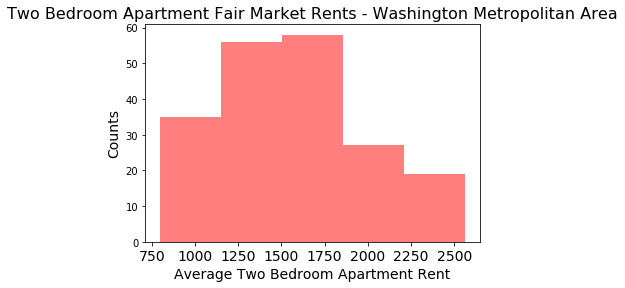

In [65]:
num_bins = 5
n, bins, patches = plt.hist(data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'], num_bins, facecolor='red', alpha=0.5)
plt.title("Two Bedroom Apartment Fair Market Rents - Washington Metropolitan Area",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Two Bedroom Apartment Rent', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

Let's define the Fair Market Rents ranges and create a new column called *Level_labels*.

In [66]:
level = []
for i in range(0,len(data_TwoBedroomAvgPrice)):
    if (data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] < 1200):
        level.append("Low Level Rent")
    elif (data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] >= 1200 and data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] < 1500):
        level.append("Mid-1 Level Rent")
    elif (data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] >= 1500 and data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] < 1800):
        level.append("Mid-2 Level Rent")
    elif (data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] >= 1800 and data_TwoBedroomAvgPrice['Two-Bedroom_AvgPrice_USD'][i] < 2600):
        level.append("High-1 Level Rent")
    else:
        level.append("High-2 Level Rent")   

data_TwoBedroomAvgPrice['Level_labels'] = level
data_TwoBedroomAvgPrice.head()

,ZipCode,Two-Bedroom_AvgPrice_USD,primary_city,county,Level_labels
0,22821,800,Dayton,Rockingham County,Low Level Rent
1,22815,800,Broadway,Rockingham County,Low Level Rent
2,22831,800,Hinton,Rockingham County,Low Level Rent
3,22844,800,New Market,Shenandoah County,Low Level Rent
4,22853,810,Timberville,Rockingham County,Low Level Rent


Before we apply the get_dummies method to analyze each Zip Code Area, let's merge the dataframes *WashingtonMA_data* and *data_TwoBedroomAvgPrice*.

In [67]:

WashingtonMA_data  = pd.merge(WashingtonMA_data , 
                    data_TwoBedroomAvgPrice[['ZipCode','Two-Bedroom_AvgPrice_USD', 'Level_labels']],
                    left_on = 'ZipCode',
                    right_on = 'ZipCode',
                    how = 'left')

In [68]:
WashingtonMA_data.head()

,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Two-Bedroom_AvgPrice_USD,Level_labels
0,20001,38.91,-77.02,ELEC,38.903359,-77.024381,Tesla Destination,2220,High-1 Level Rent
1,20001,38.91,-77.02,ELEC,38.904404,-77.026493,Tesla Destination,2220,High-1 Level Rent
2,20001,38.91,-77.02,ELEC,38.901858,-77.019793,Tesla Destination,2220,High-1 Level Rent
3,20001,38.91,-77.02,ELEC,38.902895,-77.025891,Tesla Destination,2220,High-1 Level Rent
4,20001,38.91,-77.02,ELEC,38.918455,-77.023228,Tesla Destination,2220,High-1 Level Rent


 #### Analysing Each Zip Code Area

Now, let's apply the get_dummies method to convert the categorical variables into binary values. 

In [69]:
WashingtonMA_onehot = pd.get_dummies(WashingtonMA_data[['Venue Category','Level_labels']], prefix="", prefix_sep="")

WashingtonMA_onehot['ZipCode'] = WashingtonMA_data['ZipCode']

# move neighborhood column to the first column
fixed_columns = [WashingtonMA_onehot.columns[-1]] + list(WashingtonMA_onehot.columns[:-1])
WashingtonMA_onehot = WashingtonMA_onehot[fixed_columns]

WashingtonMA_onehot.head()

,ZipCode,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bookstore,Breakfast Spot,Burger Joint,Café,Coffee Shop,Cupcake Shop,Deli / Bodega,Diner,Falafel Restaurant,Grocery Store,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Moroccan Restaurant,Music Venue,New American Restaurant,Pie Shop,Pizza Place,Ramen Restaurant,Restaurant,Rock Club,Salad Place,Sandwich Place,Sushi Restaurant,Taco Place,Tea Room,Tesla,Tesla Destination,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,High-1 Level Rent,Low Level Rent,Mid-1 Level Rent,Mid-2 Level Rent
0,20001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,20001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,20001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,20001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,20001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


Next, let's group rows by ZipCode and by taking the mean of the frequency of occurrence of each category.

In [70]:
WashingtonMA_grouped = WashingtonMA_onehot.groupby('ZipCode').mean().reset_index()
WashingtonMA_grouped.head()

,ZipCode,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bookstore,Breakfast Spot,Burger Joint,Café,Coffee Shop,Cupcake Shop,Deli / Bodega,Diner,Falafel Restaurant,Grocery Store,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Moroccan Restaurant,Music Venue,New American Restaurant,Pie Shop,Pizza Place,Ramen Restaurant,Restaurant,Rock Club,Salad Place,Sandwich Place,Sushi Restaurant,Taco Place,Tea Room,Tesla,Tesla Destination,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,High-1 Level Rent,Low Level Rent,Mid-1 Level Rent,Mid-2 Level Rent
0,20001,0.057143,0.0,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.028571,0.0,0.028571,0.000000,0.0,0.0,0.0,0.0,0.057143,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.057143,0.028571,0.0,0.0,0.000000,0.028571,0.000000,0.0,0.0,0.0,0.142857,0.028571,0.485714,0.0,1.0,0.0,0.0,0.0
1,20002,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.142857,0.000000,0.571429,0.0,0.0,0.0,0.0,1.0
2,20003,0.083333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.083333,0.000000,0.083333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.333333,0.0,1.0,0.0,0.0,0.0
3,20004,0.057143,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.057143,0.0,0.028571,0.000000,0.0,0.0,0.0,0.0,0.028571,0.028571,0.000000,0.0,0.028571,0.0,0.0,0.028571,0.0,0.0,0.0,0.028571,0.000000,0.085714,0.028571,0.0,0.0,0.057143,0.000000,0.000000,0.0,0.0,0.0,0.142857,0.000000,0.400000,0.0,1.0,0.0,0.0,0.0
4,20005,0.085714,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.028571,0.0,0.028571,0.000000,0.0,0.0,0.0,0.0,0.028571,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.028571,0.0,0.0,0.0,0.000000,0.000000,0.057143,0.028571,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.142857,0.000000,0.571429,0.0,1.0,0.0,0.0,0.0


Let's sort the venues by using the *return_most_common_venues function*

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ZipCode_sorted = pd.DataFrame(columns=columns)
ZipCode_sorted['ZipCode'] = WashingtonMA_grouped['ZipCode']

for ind in np.arange(WashingtonMA_grouped.shape[0]):
    ZipCode_sorted.iloc[ind, 1:] = return_most_common_venues(WashingtonMA_grouped.iloc[ind, :], num_top_venues)

ZipCode_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,20001,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
1,20002,Mid-2 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
2,20003,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
3,20004,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
4,20005,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination


#### Clustering Zip Code Areas

Now, we will apply the K-means clustering, an unsupervised machine learning algorithm,to cluster the Zip Code Areas into 4 clusters.

In [73]:
# set number of clusters
kclusters = 4

WashingtonMA_grouped_clustering = WashingtonMA_grouped.drop('ZipCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(WashingtonMA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels=kmeans.labels_
labels

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1,
       1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2,
       0, 0, 2, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 3, 1, 3, 0, 3, 3])

Now we create a new dataframe that includes the cluster as well as venues for each ZipCode.

In [74]:
ZipCode_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

WashingtonMA_merged = WashingtonMA_data[['ZipCode','Two-Bedroom_AvgPrice_USD', 'Level_labels']]

WashingtonMA_merged = WashingtonMA_merged.join(ZipCode_sorted.set_index('ZipCode'), on='ZipCode')

WashingtonMA_merged.head() 

,ZipCode,Two-Bedroom_AvgPrice_USD,Level_labels,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
1,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
2,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
3,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
4,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination


In [75]:
WashingtonMA_merged.groupby(['ZipCode']).head(1).reset_index(drop=True)

,ZipCode,Two-Bedroom_AvgPrice_USD,Level_labels,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
1,20002,1500,Mid-2 Level Rent,1,Mid-2 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
2,20003,2560,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
3,20004,2560,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
4,20005,2430,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
5,20006,1840,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
6,20007,2140,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
7,20008,2430,High-1 Level Rent,2,High-1 Level Rent,Italian Restaurant,Pizza Place
8,20009,2420,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination
9,20010,1740,Mid-2 Level Rent,1,Mid-2 Level Rent,Vegetarian / Vegan Restaurant,Coffee Shop


As we want to show the venues information on the map, let's group each Zip Code Area by the number of venues.

In [76]:
Count_Venue_Category = WashingtonMA_data.groupby(['ZipCode','Venue Category']).size().reset_index(name='Counts')
Count_Venue_Category = Count_Venue_Category.sort_values(['ZipCode','Counts'],ascending=False).groupby('ZipCode').head(3).reset_index(drop=True)

Count_Venue_Category['Join'] = Count_Venue_Category['Counts'].map(str) + " " + Count_Venue_Category['Venue Category']
Count_Venue_Category = Count_Venue_Category.groupby(['ZipCode'])['Join'].apply(", ".join).reset_index()

Count_Venue_Category

,ZipCode,Join
0,20001,"17 Vegetarian / Vegan Restaurant, 5 Tesla Dest..."
1,20002,"4 Vegetarian / Vegan Restaurant, 1 Pie Shop, 1..."
2,20003,"4 Vegetarian / Vegan Restaurant, 3 Tesla Desti..."
3,20004,"14 Vegetarian / Vegan Restaurant, 5 Tesla Dest..."
4,20005,"20 Vegetarian / Vegan Restaurant, 5 Tesla Dest..."
5,20006,"20 Vegetarian / Vegan Restaurant, 5 Tesla Dest..."
6,20007,"10 Vegetarian / Vegan Restaurant, 3 Tesla Dest..."
7,20008,"1 Breakfast Spot, 1 Café, 1 Grocery Store"
8,20009,"14 Vegetarian / Vegan Restaurant, 4 Tesla Dest..."
9,20010,"8 Vegetarian / Vegan Restaurant, 4 Coffee Shop..."


## 3. Results

Let's merge all new dataframes.

In [77]:
All_merged = pd.merge(WashingtonMA_merged, 
                    Count_Venue_Category[['ZipCode', 'Join']],
                    left_on = 'ZipCode',
                    right_on = 'ZipCode',
                    how = 'left')

All_merged = pd.merge(All_merged, 
                    WashingtonMA[['ZipCode', 'lat','lng']],
                    left_on = 'ZipCode',
                    right_on = 'ZipCode',
                    how = 'left')


All_merged.head()

,ZipCode,Two-Bedroom_AvgPrice_USD,Level_labels,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Join,lat,lng
0,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination,"17 Vegetarian / Vegan Restaurant, 5 Tesla Dest...",38.91,-77.02
1,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination,"17 Vegetarian / Vegan Restaurant, 5 Tesla Dest...",38.91,-77.02
2,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination,"17 Vegetarian / Vegan Restaurant, 5 Tesla Dest...",38.91,-77.02
3,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination,"17 Vegetarian / Vegan Restaurant, 5 Tesla Dest...",38.91,-77.02
4,20001,2220,High-1 Level Rent,2,High-1 Level Rent,Vegetarian / Vegan Restaurant,Tesla Destination,"17 Vegetarian / Vegan Restaurant, 5 Tesla Dest...",38.91,-77.02


Finally, Let's visualize the resulting clusters.

In [78]:
latitude = 38.91
longitude = -77.02
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, join, cluster_number, label, AveragePrice in zip(All_merged['lat'], All_merged['lng'], All_merged['ZipCode'], All_merged['Join'], All_merged['Cluster_Labels'], All_merged['Level_labels'], All_merged['Two-Bedroom_AvgPrice_USD']):
    label = folium.Popup("ZipCode"+" "+str(poi) + " / "+"Cluster"+" "+str(cluster_number) +" / "+"AverageFairRentLevel"+" "+str(label) +" / "+ "Two-Bedroom AvgPrice" + str(AveragePrice)+ "USD" +  " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)

markers_colors1 = []
for lat, lon, venue_name in zip(WashingtonMA_FreseniusDialysisCenter_venues['Venue Latitude'], WashingtonMA_FreseniusDialysisCenter_venues['Venue Longitude'], WashingtonMA_FreseniusDialysisCenter_venues['Venue']):

    folium.Marker(
        [lat, lon],
        popup='Fresenius Dialysis Center',
        icon=folium.Icon(color='blue')
).add_to(map_clusters)

folium.Marker(
    location=[38.910289, -77.042561],
    popup='Fresenius Dialysis Center',
    icon=folium.Icon(color='blue')
).add_to(map_clusters)


    
map_clusters

## 4. Conclusion

In this notebook, one can easily search for venues that are located close to each other in a zip code area within a specified radius. In Addition to venues, information on average Fair Market Rents of each zip code area will be provided. In our Example, Mr. McDreamy who is currently planning to move from New York City to Washington D.C., is looking for a neighborhood that is situated close to Fresenius Dialysis Centers, Vegan Restaurants and Tesla Charging Stations. Additionally, he wants to get information on Fair Market Rents of each neighborhood in Washington Metropolitan Area. 

For example, when Mr. Mcdreamy clicks the (red) cluster of the Zip Code 20011 on the map, he would get the following information:
-	ZipCode 20011
-	Cluster 0
-	Average Fair Rent Level: Mid-1 Level
-	Two-Bedroom Average Price 1380 USD 
-	2 Tesla Destination Charging Stations
-	2 Vegetarian/Vegan Restaurant 
-	1 Medical Center (Fresenius Dialysis Center)   

Further examples:
-	ZipCode 20036
-	Cluster 2
-	Average Fair Rent Level: High-1 Level
-	Two-Bedroom Average Price 1970 USD 
-	5 Tesla Destination Charging Stations
-	19 Vegetarian/Vegan Restaurant 


-	ZipCode 20032
-	Cluster 0
-	Average Fair Rent Level: Mid-1 Level
-	Two-Bedroom Average Price 1280 USD 
-	1 Tesla Destination Charging Stations
-	1 Vegetarian/Vegan Restaurant 
-	2 Medical Center (Fresenius Dialysis Center)


## 5. Discussion
This project can especially help those who are asking themselves „Where should I live?“ when planning to move to another place. One can prioritize „must-haves“ during exploring neighborhoods, add new venue categories, and compare rents or house prices in each neighborhood.

The crime rates of a neighborhood may also play a role in deciding where to live. If one wants to factor in crime statistics when making a decision, the crime dataset can be downloaded from Metropolitan Police Department and used when clustering neighborhoods in Washington Metropolitan Area. It’s up to user to add additional factors when applying k-means clustering algorithm. 
